## The Data

At this link, you will find a dataset containing information about heart disease patients: https://www.dropbox.com/scl/fi/0vrpdnq5asmeulc4gd50y/ha_1.csv?rlkey=ciisalceotl77ffqhqe3kujzv&dl=1

A description of the original dataset can be found here: https://archive.ics.uci.edu/dataset/45/heart+disease (However, this dataset has been cleaned and reduced, and the people have been given fictious names.)

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import SVC

## 1. Logistic Regression

Fit a Logistic Regression using only `age` and `chol` (cholesterol) as predictors.

For a 55 year old, how high would their cholesterol need to be for the doctors to predict heart disease is present?

How high for the doctors to estimate a 90% chance that heart disease is present?

In [2]:
df = pd.read_csv('https://www.dropbox.com/scl/fi/0vrpdnq5asmeulc4gd50y/ha_1.csv?rlkey=ciisalceotl77ffqhqe3kujzv&dl=1')

X = df[['age', 'chol']]
y = df['diagnosis']

Dataset loaded and features/target extracted.
First 5 rows of X:
   age  chol
0   60   230
1   60   318
2   62   263
3   43   303
4   66   302
First 5 rows of y:
0    No Disease
1       Disease
2    No Disease
3       Disease
4       Disease
Name: diagnosis, dtype: object


In [4]:
logreg = LogisticRegression()
logreg.fit(X, y)


LogisticRegression()

In [13]:
logreg.intercept_

array([-3.24011226])

In [8]:
logreg.coef_

array([[0.04686331, 0.00180124]])

In [10]:
intercept = logreg.intercept_[0]
age_coef = logreg.coef_[0][0]
chol_coef = logreg.coef_[0][1]

# divide by intercept to find satisfying value
cholesterol_disease_logreg = (0 - intercept - (age_coef * 55)) / chol_coef

cholesterol_disease_logreg

np.float64(367.8748897985677)

In [11]:
target_logit = np.log(0.9 / (1 - 0.9))

cholesterol_90_disease_logreg = (target_logit - intercept - (age_coef * 55)) / chol_coef

print("90% chance: ",  cholesterol_90_disease_logreg)

90% chance:  1587.7158792754383


## 2. Linear Discriminant Analysis

Fit an LDA model using only `age` and `chol` (cholesterol)  as predictors.

For a 55 year old, how high would their cholesterol need to be for the doctors to predict heart disease is present?

In [12]:
lda = LinearDiscriminantAnalysis()
lda.fit(X, y)

LinearDiscriminantAnalysis()

In [14]:
intercept = lda.intercept_[0]
age_coef = lda.coef_[0][0]
chol_coef = lda.coef_[0][1]

# how high cholestoral for disease?
cholesterol_disease_lda = (0 - intercept - (age_coef * 55)) / chol_coef
cholesterol_disease_lda

np.float64(368.235357529938)

## 3. Support Vector Classifier

Fit an SVC model using only `age` and `chol` as predictors.  Don't forget to tune the regularization parameter.

For a 55 year old, how high would their cholesterol need to be for the doctors to predict heart disease is present?

In [17]:
# svc + tune regularization paramter
svc = SVC()
param_grid = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto']
}

grid_search = GridSearchCV(svc, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X, y)

GridSearchCV(cv=5, estimator=SVC(), n_jobs=-1,
             param_grid={'C': [0.1, 1, 10, 100], 'gamma': ['scale', 'auto'],
                         'kernel': ['linear', 'rbf']},
             scoring='accuracy')

In [18]:
best_svc_model = grid_search.best_estimator_
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print(f"Best parameters found: {best_params}")
print(f"Best cross-validation accuracy: {best_score}")

Best parameters found: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
Best cross-validation accuracy: 0.6175609756097562


In [21]:
best_svc = SVC(C=10, kernel = "linear")
best_svc.fit(X, y)

intercept = best_svc.intercept_[0]
age_coef = best_svc.coef_[0][0]
chol_coef = best_svc.coef_[0][1]

cholesterol_disease_svc = (0 - intercept - (age_coef * 55)) / chol_coef
cholesterol_disease_svc

np.float64(312.72538621511626)

## 4. Comparing Decision Boundaries

Make a scatterplot of `age` and `chol`, coloring the points by their true disease outcome.  Add a line to the plot representing the **linear separator** (aka **decision boundary**) for each of the three models above.

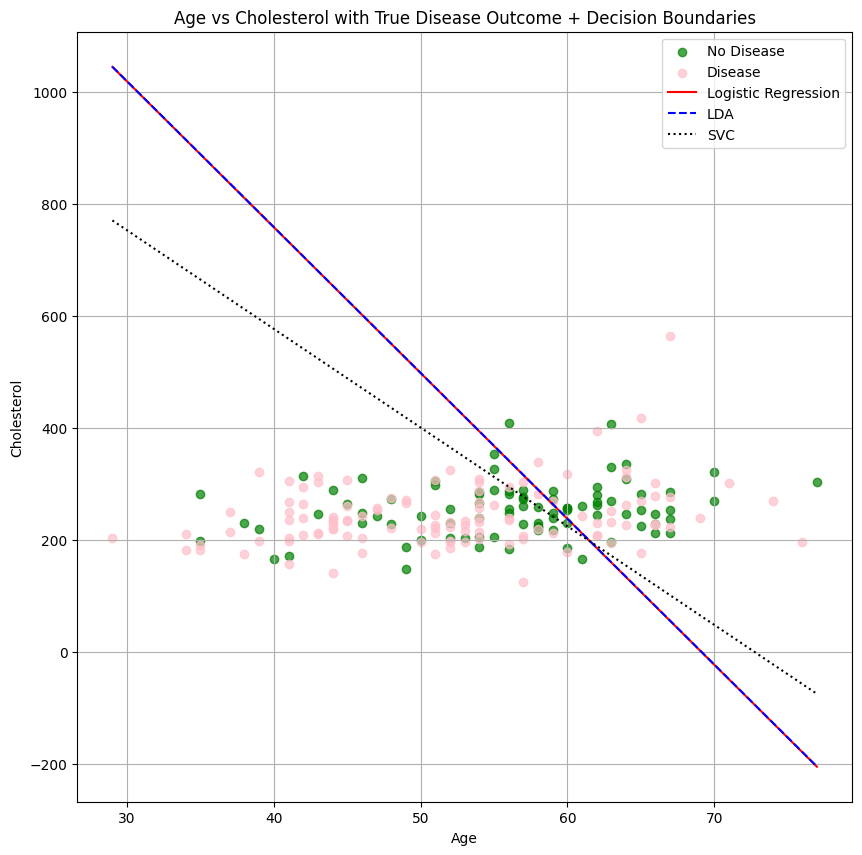

In [40]:
plt.figure(figsize=(10, 10))

diagnosis_colors = {'No Disease': 'green', 'Disease': 'pink'}
for diagnosis_type, color in diagnosis_colors.items():
    subset = df[df['diagnosis'] == diagnosis_type]
    plt.scatter(subset['age'], subset['chol'], color=color, label=diagnosis_type, alpha=0.7)

# Set labels and title
plt.xlabel('Age')
plt.ylabel('Cholesterol')
plt.title('Age vs Cholesterol with True Disease Outcome + Decision Boundaries')

# series of all ages
age_range = np.array([X['age'].min(), X['age'].max()])

# --- Logistic Regression Decision Boundary ---
logreg_intercept = logreg.intercept_[0]
logreg_age_coef = logreg.coef_[0][0]
logreg_chol_coef = logreg.coef_[0][1]

chol_logreg_boundary = (-logreg_intercept - logreg_age_coef * age_range) / logreg_chol_coef
plt.plot(age_range, chol_logreg_boundary, color='red', linestyle='-', label='Logistic Regression')

# --- LDA Decision Boundary ---
lda_intercept = lda.intercept_[0]
lda_age_coef = lda.coef_[0][0]
lda_chol_coef = lda.coef_[0][1]

chol_lda_boundary = (-lda_intercept - lda_age_coef * age_range) / lda_chol_coef
plt.plot(age_range, chol_lda_boundary, color='blue', linestyle='--', label='LDA')

# --- SVC (Linear Kernel) Decision Boundary ---
svc_intercept = best_svc.intercept_[0]
svc_age_coef = best_svc.coef_[0][0]
svc_chol_coef = best_svc.coef_[0][1]

chol_svc_boundary = (-svc_intercept - svc_age_coef * age_range) / svc_chol_coef
plt.plot(age_range, chol_svc_boundary, color='black', linestyle=':', label='SVC')

plt.legend()
plt.grid(True)
plt.show()